In [6]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import HuberRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from scipy.stats import f_oneway
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.model_selection import KFold
import lightgbm as lgb
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import matplotlib.pyplot as plt
import shap
import scipy
import pickle

In [8]:
def evaluar_modelo_regresion(y_true, y_pred):

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    metrics = {
        'Mean Absolute Error (MAE)': mae,
        'Mean Squared Error (MSE)': mse,
        'Root Mean Squared Error (RMSE)': rmse,
        'R² Score': r2
    }

    return metrics

In [9]:
training_database=pd.read_csv('training_database.csv')
columns=training_database.columns
X=training_database.drop(columns=['price','id'])
y=training_database['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234,shuffle=True)

# Entrenamiento de distintos de modelos

In [10]:
columnas_categoricas = X.select_dtypes(include=['object', 'bool']).columns
columnas_numericas = X.select_dtypes(include=['int', 'float']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), columnas_numericas),  
        ('cat', OneHotEncoder(categories='auto',handle_unknown='infrequent_if_exist',drop='if_binary',min_frequency=30), columnas_categoricas)  
    ])
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  
    ('regressor', HuberRegressor(epsilon=1.35,   max_iter=1000,  alpha=0,  warm_start=False,
                    fit_intercept=True, tol=1e-05))  
])

pipeline.fit(X_train, y_train)
y_pred_hubber = pipeline.predict(X_test)
metrics_huber = evaluar_modelo_regresion(y_test, y_pred_hubber)
for metric, value in metrics_huber.items():
    print(f'{metric}: {value}')

pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('regressor', XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3, learning_rate=0.1))
])

pipeline_xgb.fit(X_train, y_train)
y_pred_xgboost = pipeline_xgb.predict(X_test)

metrics_xgboost = evaluar_modelo_regresion(y_test, y_pred_xgboost)
for metric, value in metrics_xgboost.items():
    print(f'{metric}: {value}')

pipeline_lgbm = Pipeline(steps=[
    ('preprocessor', preprocessor),  
    ('regressor', LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=3))
])

pipeline_lgbm.fit(X_train, y_train)
y_pred_lgbm = pipeline_lgbm.predict(X_test)

metrics_lgbm = evaluar_modelo_regresion(y_test, y_pred_lgbm)
for metric, value in metrics_lgbm.items():
    print(f'{metric}: {value}')

errors_huber = abs(y_test - y_pred_hubber)
errors_xgb = abs(y_test - y_pred_xgboost)
errors_lgbm = abs(y_test - y_pred_lgbm)

anova_stat, p_value = f_oneway(errors_huber, errors_xgb, errors_lgbm)

print(f"ANOVA: {anova_stat}, p-value: {p_value}")



/Users/nadiatamayo/envs/mcdi/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/nadiatamayo/envs/mcdi/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Mean Absolute Error (MAE): 597.376803582597
Mean Squared Error (MSE): 8102116.289404144
Root Mean Squared Error (RMSE): 2846.421664020309
R² Score: 0.23464623768003834
Mean Absolute Error (MAE): 561.7945193581478
Mean Squared Error (MSE): 2231112.03475689
Root Mean Squared Error (RMSE): 1493.6907426763046
R² Score: 0.7892414859322993
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000683 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 923
[LightGBM] [Info] Number of data points in the train set: 2940, number of used features: 43
[LightGBM] [Info] Start training from score 1135.639999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

/Users/nadiatamayo/envs/mcdi/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


# Hyperparameter tunning 

In [98]:

pipeline_lgbm_kfold = Pipeline(steps=[
    ('preprocessor', preprocessor),  
    ('regressor', LGBMRegressor(boosting_type='gbdt',
                      learning_rate=0.01,
                      num_leaves=20,
                      n_estimators=850,
                      max_depth=20,
                      min_child_samples=70,
                      subsample=0.6,
                      colsample_bytree=0.9,
                      random_state=42,
                      verbose=-1
                     ))
])

kf = KFold(n_splits=10, shuffle=True, random_state=42)
train_scores = []
val_scores = []

for fold, (train_index, val_index) in enumerate(kf.split(X), 1):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    pipeline_lgbm_kfold.fit(X_train, y_train)

    y_train_pred = pipeline_lgbm_kfold.predict(X_train)
    y_val_pred = pipeline_lgbm_kfold.predict(X_val)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

    train_scores.append(train_rmse)
    val_scores.append(val_rmse)

    print(f"Fold {fold}: RMSE Entrenamiento = {train_rmse:.4f}, RMSE Validacion= {val_rmse:.4f}")

mean_train_rmse = np.mean(train_scores)
mean_val_rmse = np.mean(val_scores)

print(f"\nMedia entrenamiento RMSE: {mean_train_rmse:.4f}")
print(f"Media validación RMSE: {mean_val_rmse:.4f}")

y_pred_lgbm_kfold= pipeline_lgbm_kfold.predict(X_test)

metrics_lgbm_kfold = evaluar_modelo_regresion(y_test, y_pred_lgbm_kfold)
for metric, value in metrics_lgbm_kfold.items():
    print(f'{metric}: {value}')

/Users/nadiatamayo/envs/mcdi/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Fold 1: RMSE Entrenamiento = 1897.9309, RMSE Validacion= 3193.0431
Fold 2: RMSE Entrenamiento = 2025.8125, RMSE Validacion= 1362.3382
Fold 3: RMSE Entrenamiento = 2021.7484, RMSE Validacion= 1419.1760


/Users/nadiatamayo/envs/mcdi/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Fold 4: RMSE Entrenamiento = 1803.1471, RMSE Validacion= 3406.5367
Fold 5: RMSE Entrenamiento = 2038.3981, RMSE Validacion= 2115.9706


/Users/nadiatamayo/envs/mcdi/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Fold 6: RMSE Entrenamiento = 1991.1110, RMSE Validacion= 1841.7394


/Users/nadiatamayo/envs/mcdi/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Fold 7: RMSE Entrenamiento = 2033.6259, RMSE Validacion= 1562.3721
Fold 8: RMSE Entrenamiento = 1991.3153, RMSE Validacion= 1867.7749


/Users/nadiatamayo/envs/mcdi/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Fold 9: RMSE Entrenamiento = 2071.5790, RMSE Validacion= 1280.2420
Fold 10: RMSE Entrenamiento = 1940.7947, RMSE Validacion= 2801.1873

Media entrenamiento RMSE: 1981.5463
Media validación RMSE: 2085.0380
Mean Absolute Error (MAE): 611.9940852339068
Mean Squared Error (MSE): 3992764.9393925588
Root Mean Squared Error (RMSE): 1998.1904161997572
R² Score: 0.6228296954439211


In [99]:


def objective(params):
    params['num_leaves'] = int(params['num_leaves'])
    params['min_data_in_leaf'] = int(params['min_data_in_leaf'])
    params['subsample_for_bin'] = int(params['subsample_for_bin']) 
    lgbm_tunned = Pipeline(steps=[
    ('preprocessor', preprocessor),  
    ('regressor', LGBMRegressor(n_estimators=1000,
        **params
                     ))])
    lgbm_tunned.fit(X_train, y_train)
    preds = lgbm_tunned.predict(X_test)
    rmse = np.sqrt(np.mean((preds - y_test) ** 2))
    return {'loss': rmse, 'status': STATUS_OK}

search_space = {
    'num_leaves': hp.quniform('num_leaves', 10, 50, 1),  
    'max_depth': hp.choice('max_depth', [-1, 10, 20]), 
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 2000, 50000, 2000),
    'feature_fraction': hp.uniform('feature_fraction', 0.7, 1.0),
    'min_data_in_leaf': hp.qloguniform('min_data_in_leaf', 0, 4, 1),  
    'bagging_fraction': hp.uniform('bagging_fraction', 0.7, 1.0),
    'lambda_l2': hp.uniform('lambda_l2', 0.0, 1.0),
}


trials = Trials()

best_params = fmin(
    fn=objective,  
    space=search_space,  
    algo=tpe.suggest,  
    max_evals=100,
    trials=trials,  
    rstate=np.random.default_rng(42)  
)


100%|██████████| 100/100 [08:10<00:00,  4.90s/trial, best loss: 769.3202647403358]


In [100]:
print(best_params)
best_params['num_leaves']=int(best_params['num_leaves'])
best_params['min_data_in_leaf'] = int(best_params['min_data_in_leaf'])
best_params['subsample_for_bin'] = int(best_params['subsample_for_bin']) 


{'bagging_fraction': 0.9379912058908335, 'feature_fraction': 0.7308386459185976, 'lambda_l2': 0.1827286916839157, 'learning_rate': 0.18851988217343157, 'max_depth': 0, 'min_data_in_leaf': 41.0, 'num_leaves': 37.0, 'subsample_for_bin': 40000.0}


In [101]:
'''with open("best_params.txt", "w") as file:
    for key, value in best_params.items():
        file.write(f"{key}: {value}\n")'''

'with open("best_params.txt", "w") as file:\n    for key, value in best_params.items():\n        file.write(f"{key}: {value}\n")'

In [102]:
lgbm_tunned = Pipeline(steps=[
    ('preprocessor', preprocessor),  
    ('regressor', LGBMRegressor(n_estimators=1000,
    **best_params                     ))])

lgbm_tunned.fit(X_train, y_train)

preds_tunned = lgbm_tunned.predict(X_test)

metrics_lgbm_tunned_testing = evaluar_modelo_regresion(y_test, preds_tunned)
for metric, value in metrics_lgbm_tunned_testing.items():
    print(f'{metric}: {value}')


Mean Absolute Error (MAE): 213.07874275029616
Mean Squared Error (MSE): 591853.6697401403
Root Mean Squared Error (RMSE): 769.3202647403358
R² Score: 0.9440914673773702


In [103]:
preds_trained=lgbm_tunned.predict(X_train)
metrics_lgbm_tunned_preds_trained = evaluar_modelo_regresion(y_train, preds_trained)
for metric, value in metrics_lgbm_tunned_preds_trained.items():
    print(f'{metric}: {value}')

Mean Absolute Error (MAE): 133.35667500801242
Mean Squared Error (MSE): 84670.57898615608
Root Mean Squared Error (RMSE): 290.9820939270251
R² Score: 0.9921584905372505


# Importancia de variables

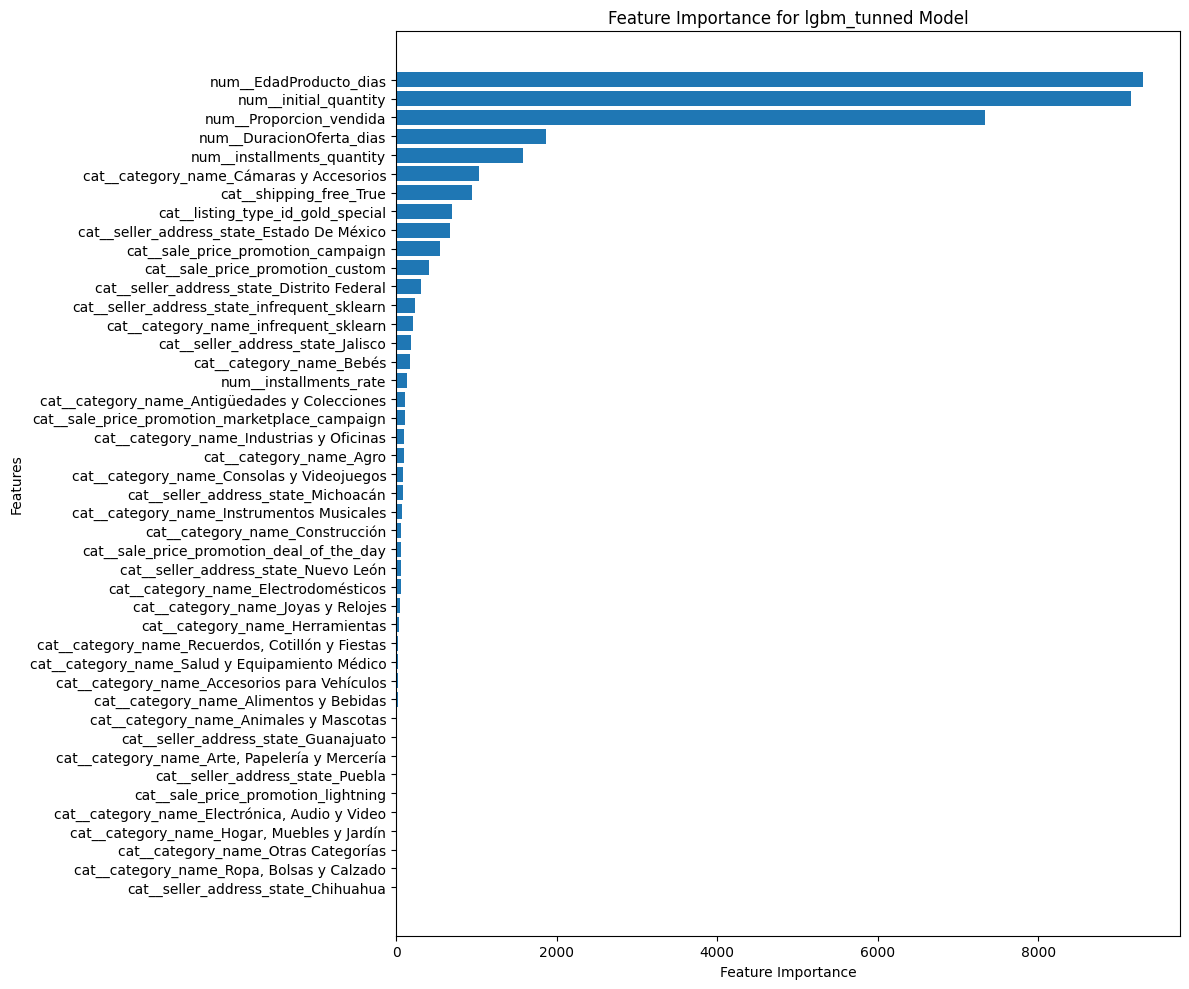

In [115]:
lgbm_model = lgbm_tunned.named_steps['regressor']  

importance = lgbm_model.booster_.feature_importance()

feature_names = lgbm_tunned['preprocessor'].get_feature_names_out()

importance_dict = dict(zip(feature_names, importance))

sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

features, importance_values = zip(*sorted_importance)

plt.figure(figsize=(12, 10))
plt.barh(features, importance_values)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance for lgbm_tunned Model')
plt.gca().invert_yaxis()  
plt.tight_layout()
plt.show()

In [118]:

lgbm_model = lgbm_tunned.named_steps['regressor']
explainer = shap.TreeExplainer(lgbm_model)
X_transformed = lgbm_tunned.named_steps['preprocessor'].transform(X)  
shap_values = explainer.shap_values(X_transformed)

In [133]:
explainer = shap.TreeExplainer(lgbm_model)
X_transformed = lgbm_tunned.named_steps['preprocessor'].transform(X_test)  
if isinstance(X_transformed, scipy.sparse.csr_matrix):
    X_transformed = X_transformed.toarray()
shap_values = explainer.shap_values(X_transformed)

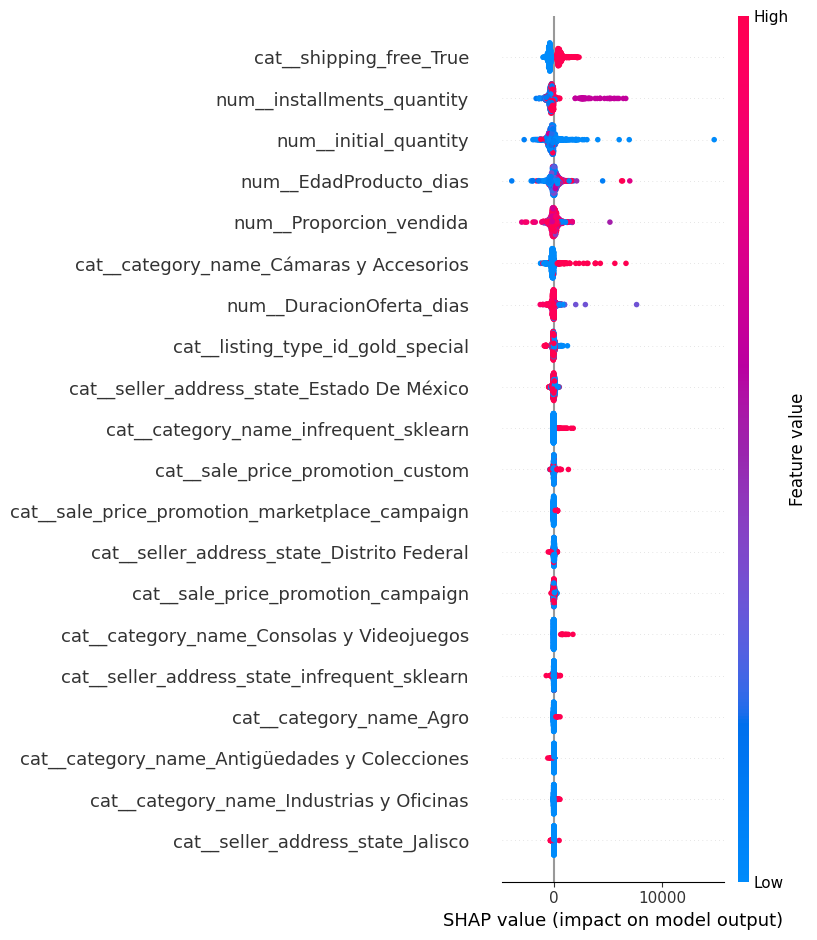

In [139]:
shap.summary_plot(shap_values, X_transformed,feature_names)

In [144]:

with open('lgbm_tunned.pkl', 'wb') as file:
    pickle.dump(lgbm_tunned, file)